In [1]:
import pandas as pd
import time
import re
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
import os
import tweepy as tw
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pickle
from keras.models import load_model

Using TensorFlow backend.
C:\Users\LENOVO\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\LENOVO\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\LENOVO\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\LENOVO\anaconda3\lib\site-packages\tensorflow\python\framework\dtype

In [2]:
start_time = time.time()

# csv = './sentiment_tweets.csv'
# my_df = pd.read_csv(csv,index_col=0)
# x = my_df.text
# y = my_df.target
# SEED = 2000
# x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
# tokenizer = Tokenizer(num_words=100000)
# tokenizer.fit_on_texts(x_train)
# with open('tokenizer.pickle','wb') as handle:
#     pickle.dump(tokenizer,handle,protocol = pickle.HIGHEST_PROTOCOL)

with open('./Models/tokenizer.pickle','rb') as handle:
    tokenizer = pickle.load(handle)

In [3]:
def authenticate():
    consumer_key = "ugDc5vsJPr72kxiHbISR15SJU"
    consumer_secret_key = "wDFQ4xRrUTMsZfhqGRKdQiqF2ZQ6YHDalEtfBpUwUARPhkJyPL"
    access_token = "2377130262-okTKiPKVWKt0pGwgj4wyPPUFRPpvEuyZvVtOrKw"
    access_token_secret = "rrONH7xppgmsWct3uUAjwFJj65fcEjuQcwgmFYVHQ309c"
    auth = tw.OAuthHandler(consumer_key,consumer_secret_key)
    auth.set_access_token(access_token,access_token_secret)
    return tw.API(auth,wait_on_rate_limit=True)

def get_tweets():
    api = authenticate()
    search_user = str(input("Enter the Twitter Id of a person: "))
    x_input = []
    n = int(input("Enter number of Recent Tweets to anlyze: "))
    try:
        Tweets = tw.Cursor(api.user_timeline,search_user,exclude_replies = True).items(n)
        for tweet in Tweets:
            x_input.append(tweet.text)
    except tw.TweepError:
        print("Error Occured")
    return (x_input)

def predictions(tweet_texts,tokenizer):
    sequences_test = tokenizer.texts_to_sequences(tweet_texts)
    x_test_seq = pad_sequences(sequences_test, maxlen=45)
    model = load_model('./Models/CNN_best_weights.02-0.8292.hdf5')
    output_senti = model.predict(x_test_seq)
    test_result = []
    for i in output_senti:
        test_result.append(i[0])
    return test_result

def tweet_cleaner(text):
    tok = WordPunctTokenizer()
    pat1 = r'@[A-Za-z0-9]+'
    pat2 = r'https?://[A-Za-z0-9./]+'
    combined_pat = r'|'.join((pat1, pat2))
    www_pat = r'www.[^ ]+'
    negations_dic = {"isn't": "is not", "aren't": "are not", "wasn't": "was not", "weren't": "were not",
                     "haven't": "have not", "hasn't": "has not", "hadn't": "had not", "won't": "will not",
                     "wouldn't": "would not", "don't": "do not", "doesn't": "does not", "didn't": "did not",
                     "can't": "can not", "couldn't": "could not", "shouldn't": "should not", "mightn't": "might not",
                     "mustn't": "must not","I'm":"I am","he's":"he is","she's":"she is","that's":"that is","where's":"where is",
                    "how's":"how is","\'ll":" will","\'re": " are","\'d":" would","\'ve":" have","let's":"let us","you're":"you are","it's":"it is"}
    neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '',souped)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(
        lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    words = [x for x in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [10]:
x_input = get_tweets()
n = len(x_input)
print("Cleaning and parsing the tweets...\n")
clean_tweet_texts = []
for i in range(0, n):
    clean_tweet_texts.append(tweet_cleaner(x_input[i]))
print("Cleaned and parsed Tweets...")
print("Predicting the values...")
output_senti = predictions(clean_tweet_texts,tokenizer)
tweet_number = list(i for i in range(1,n+1))

Enter the Twitter Id of a person: BarackObama
Enter number of Recent Tweets to anlyze: 20
Cleaning and parsing the tweets...

Cleaned and parsed Tweets...
Predicting the values...


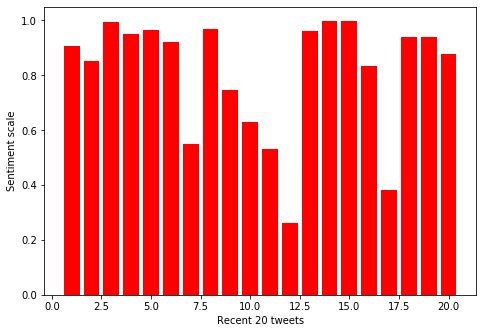

In [11]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(tweet_number,output_senti,color = 'r')
plt.ylabel("Sentiment scale")
plt.xlabel("Recent "+str(n)+" tweets")
plt.show()
end_time = time.time()
time_taken = end_time-start_time

In [12]:
print(time_taken)
print(output_senti)

209.39623022079468
[0.9054667, 0.8535133, 0.9941201, 0.9498991, 0.96322584, 0.92226315, 0.54826534, 0.96837306, 0.74496, 0.6292883, 0.53002733, 0.26241046, 0.9629547, 0.99954146, 0.9974657, 0.8345058, 0.38168, 0.9409772, 0.94034266, 0.87593]


In [13]:
average = ((sum(output_senti)*100)//n )
print(str(average) + "% of his tweets are positive")
if average in range(0,43):
    print("The user is a negative influencer")
elif average in range(43,64):
    print("The user is a neutral influencer")
else:
    print("The user is a positive influencer")

81.0% of his tweets are positive
The user is a positive influencer
